In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Set a random state for reproducibility
RANDOM_STATE = 42

print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:
# Define file paths
impact_file = '../data/results/policy_impact_database_V2_local.csv'
features_file = '../data/results/india_policies_featurized_local.csv'

# Load the datasets
try:
    df_impact = pd.read_csv(impact_file)
    df_features = pd.read_csv(features_file)
    print(f"Impact data loaded. Shape: {df_impact.shape}")
    print(f"Features data loaded. Shape: {df_features.shape}")

except FileNotFoundError as e:
    print(e)
    print("Please make sure the file paths are correct and the files exist.")

# Merge the dataframes
if 'df_impact' in locals() and 'df_features' in locals():
    print(f"\nImpact columns: {df_impact.columns.to_list()}")
    print(f"Features columns: {df_features.columns.to_list()}")

    # --- THIS IS THE FIX ---
    # Merge using the correct column names from each dataframe
    print("\nMerging on (policy, policy_year) and (Policy, Year)...")
    df_merged = pd.merge(
        df_impact, 
        df_features, 
        left_on=['policy', 'policy_year'], 
        right_on=['Policy', 'Year'],
        how='inner'
    )
    
    # We can drop the redundant columns from the right dataframe
    df_merged = df_merged.drop(columns=['Policy', 'Year'])
    
    print(f"Merged dataframe shape: {df_merged.shape}")
    print(f"Merged columns: {df_merged.columns.to_list()}")
    display(df_merged.head())

[Errno 2] No such file or directory: '../data/results/policy_impact_database_V2_local.csv'
Please make sure the file paths are correct and the files exist.

Impact columns: ['policy', 'policy_year', 'pollutant', 'ate', 'p_value_ate', 'p_value_placebo']
Features columns: ['Year', 'Policy', 'policy_type', 'action_type', 'Policy_Content']

Merging on (policy, policy_year) and (Policy, Year)...
Merged dataframe shape: (9712, 9)
Merged columns: ['policy', 'policy_year', 'pollutant', 'ate', 'p_value_ate', 'p_value_placebo', 'policy_type', 'action_type', 'Policy_Content']


,policy,policy_year,pollutant,ate,p_value_ate,p_value_placebo,policy_type,action_type,Policy_Content
0,National Building Code of India 2016 (vol I an...,1970,EDGAR_BC_1970_2022,-1840.9449,0.0000,0.0,BuildingCode,Regulation,The National Building Code of India is a natio...
1,National Building Code of India 2016 (vol I an...,1970,EDGAR_CO_1970_2022,-88065.6252,0.0000,0.0,BuildingCode,Regulation,The National Building Code of India is a natio...
2,National Building Code of India 2016 (vol I an...,1970,EDGAR_NH3_1970_2022,-7394.7556,0.0180,0.0,BuildingCode,Regulation,The National Building Code of India is a natio...
3,National Building Code of India 2016 (vol I an...,1970,EDGAR_NMVOC_1970_2022,-7825.9830,0.0002,0.0,BuildingCode,Regulation,The National Building Code of India is a natio...
4,National Building Code of India 2016 (vol I an...,1970,EDGAR_NOx_1970_2022,-11576.4264,0.0003,0.0,BuildingCode,Regulation,The National Building Code of India is a natio...


In [6]:
# Define our feature and target columns
target_col = 'ate'
# These columns are all in our new 'df_merged'
feature_cols = ['policy_type', 'action_type', 'pollutant', 'policy_year']

# 1. Handle Missing Values
print(f"Original shape: {df_merged.shape}")
print(f"Missing 'ate' values before drop: {df_merged[target_col].isnull().sum()}")

# Drop rows where the target 'ate' is missing
df_model_data = df_merged.dropna(subset=[target_col])

# Also, let's drop rows where any of our features are missing
df_model_data = df_model_data.dropna(subset=feature_cols)

print(f"Shape after dropping NaNs in target & features: {df_model_data.shape}")

# 2. One-Hot Encode Categorical Features
categorical_features = ['policy_type', 'action_type', 'pollutant']

print(f"\nUnique values in 'policy_type': {df_model_data['policy_type'].nunique()}")
print(f"Unique values in 'action_type': {df_model_data['action_type'].nunique()}")
print(f"Unique values in 'pollutant': {df_model_data['pollutant'].nunique()}")

# Using pd.get_dummies
df_processed = pd.get_dummies(df_model_data[feature_cols + [target_col]], 
                              columns=categorical_features, 
                              drop_first=True) # drop_first avoids dummy variable trap

print("\nData after One-Hot Encoding:")
display(df_processed.head())

# 3. Finalize X and y
y = df_processed[target_col]
X = df_processed.drop(columns=[target_col])

print(f"\nFinal shapes:")
print(f"X (features): {X.shape}")
print(f"y (target):   {y.shape}")

Original shape: (9712, 9)
Missing 'ate' values before drop: 0
Shape after dropping NaNs in target & features: (9712, 9)

Unique values in 'policy_type': 99
Unique values in 'action_type': 49
Unique values in 'pollutant': 16

Data after One-Hot Encoding:


,policy_year,ate,policy_type_AirQualityStandard,policy_type_BiodiversityConservation,policy_type_Biofuel,policy_type_Biofuels,policy_type_Biosafety,policy_type_BuildingCode,policy_type_BuildingEnergyEfficiency,policy_type_BuildingStandards,...,pollutant_EDGAR_PM10_1970_2022,pollutant_EDGAR_PM2,pollutant_EDGAR_SO2_1970_2022,pollutant_HCB_1970_2018,pollutant_PAH_BaP_1970_2018,pollutant_PAH_BbF_1970_2018,pollutant_PAH_BkF_1970_2018,pollutant_PAH_IcdP_1970_2018,pollutant_PCB_1970_2018,pollutant_PCDD_F_1970_2018
0,1970,-1840.9449,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1970,-88065.6252,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1970,-7394.7556,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1970,-7825.9830,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1970,-11576.4264,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False



Final shapes:
X (features): (9712, 162)
y (target):   (9712,)


In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE)

print("Data split complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

Data split complete.
X_train shape: (7769, 162)
y_train shape: (7769,)
X_test shape:  (1943, 162)
y_test shape:  (1943,)


In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("Initializing and training the XGBoost Regressor...")

# 1. Initialize the model
# We use 'reg:squarederror' as the objective because this is a regression task.
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                          n_estimators=100,      # Number of trees
                          learning_rate=0.1,   
                          max_depth=5,           
                          random_state=RANDOM_STATE)

# 2. Train the model
xg_reg.fit(X_train, y_train)

print("Model training complete.")

# 3. Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# 4. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"  Target variable range (y_test): {y_test.min():.4f} to {y_test.max():.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  R-squared (R²): {r2:.4f}")

Initializing and training the XGBoost Regressor...
Model training complete.

--- Model Evaluation ---
  Target variable range (y_test): -88065.6252 to 156.7053
  Root Mean Squared Error (RMSE): 284.9770
  R-squared (R²): 0.9826


Plotting feature importance...


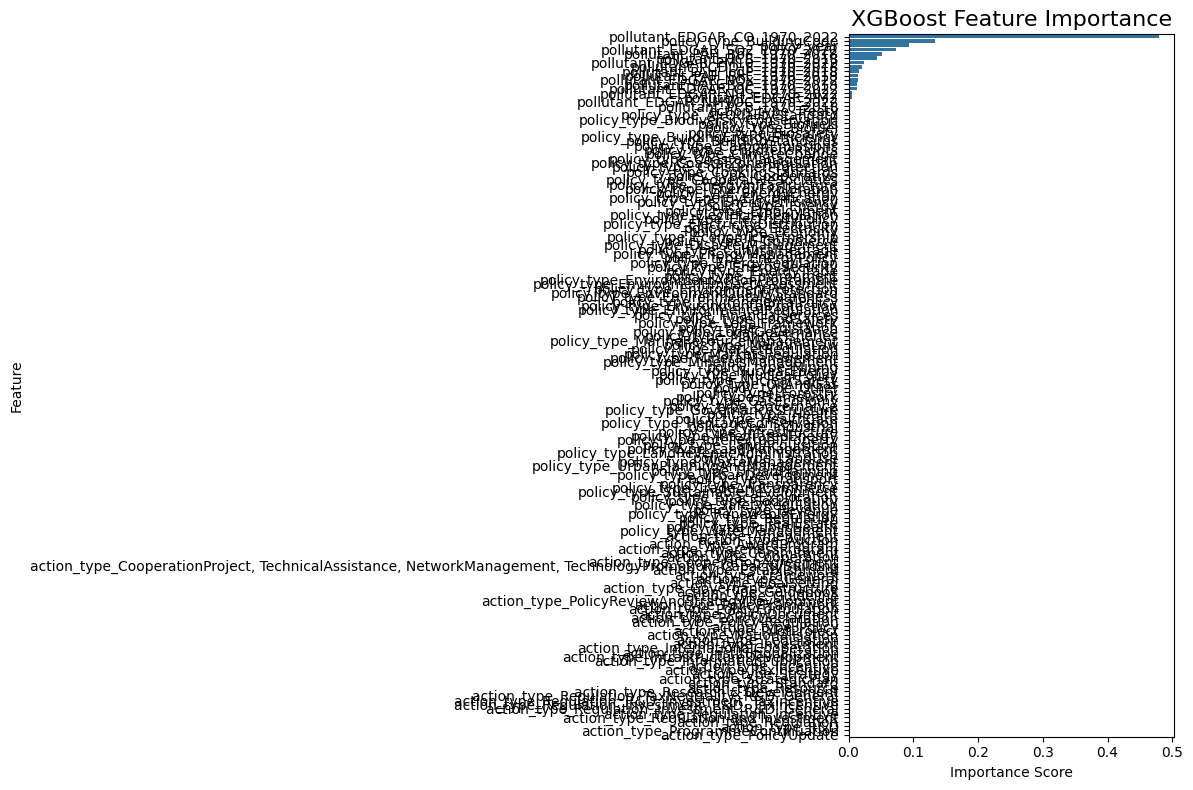


Top 5 most important features:


,feature,importance
147,pollutant_EDGAR_CO_1970_2022,0.478759
6,policy_type_BuildingCode,0.133627
0,policy_year,0.093538
154,pollutant_EDGAR_SO2_1970_2022,0.072589
157,pollutant_PAH_BbF_1970_2018,0.051055


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Plotting feature importance...")

# Get feature importance from the trained model
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xg_reg.feature_importances_
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
display(feature_importances.head())

In [12]:
# 1. Split the data
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, 
                                                                test_size=0.2, 
                                                                random_state=RANDOM_STATE)

print("Data split (v2) complete.")
print(f"X_train_v2 shape: {X_train_v2.shape}")
print(f"X_test_v2 shape:  {X_test_v2.shape}")


# 2. Initialize and train the v2 model
print("\nInitializing and training the XGBoost Regressor (v2)...")

xg_reg_v2 = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             learning_rate=0.1, 
                             max_depth=5, 
                             random_state=RANDOM_STATE)

xg_reg_v2.fit(X_train_v2, y_train_v2)
print("Model training (v2) complete.")

# 3. Make predictions and evaluate
y_pred_v2 = xg_reg_v2.predict(X_test_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v2))
r2_v2 = r2_score(y_test_v2, y_pred_v2)

print("\n--- Model Evaluation (v2) ---")
print(f"  Target variable range (y_test_v2): {y_test_v2.min():.4f} to {y_test_v2.max():.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_v2:.4f}")
print(f"  R-squared (R²): {r2_v2:.4f}")

Data split (v2) complete.
X_train_v2 shape: (7769, 147)
X_test_v2 shape:  (1943, 147)

Initializing and training the XGBoost Regressor (v2)...
Model training (v2) complete.

--- Model Evaluation (v2) ---
  Target variable range (y_test_v2): -88065.6252 to 156.7053
  Root Mean Squared Error (RMSE): 2003.5425
  R-squared (R²): 0.1409


Plotting feature importance (v2)...


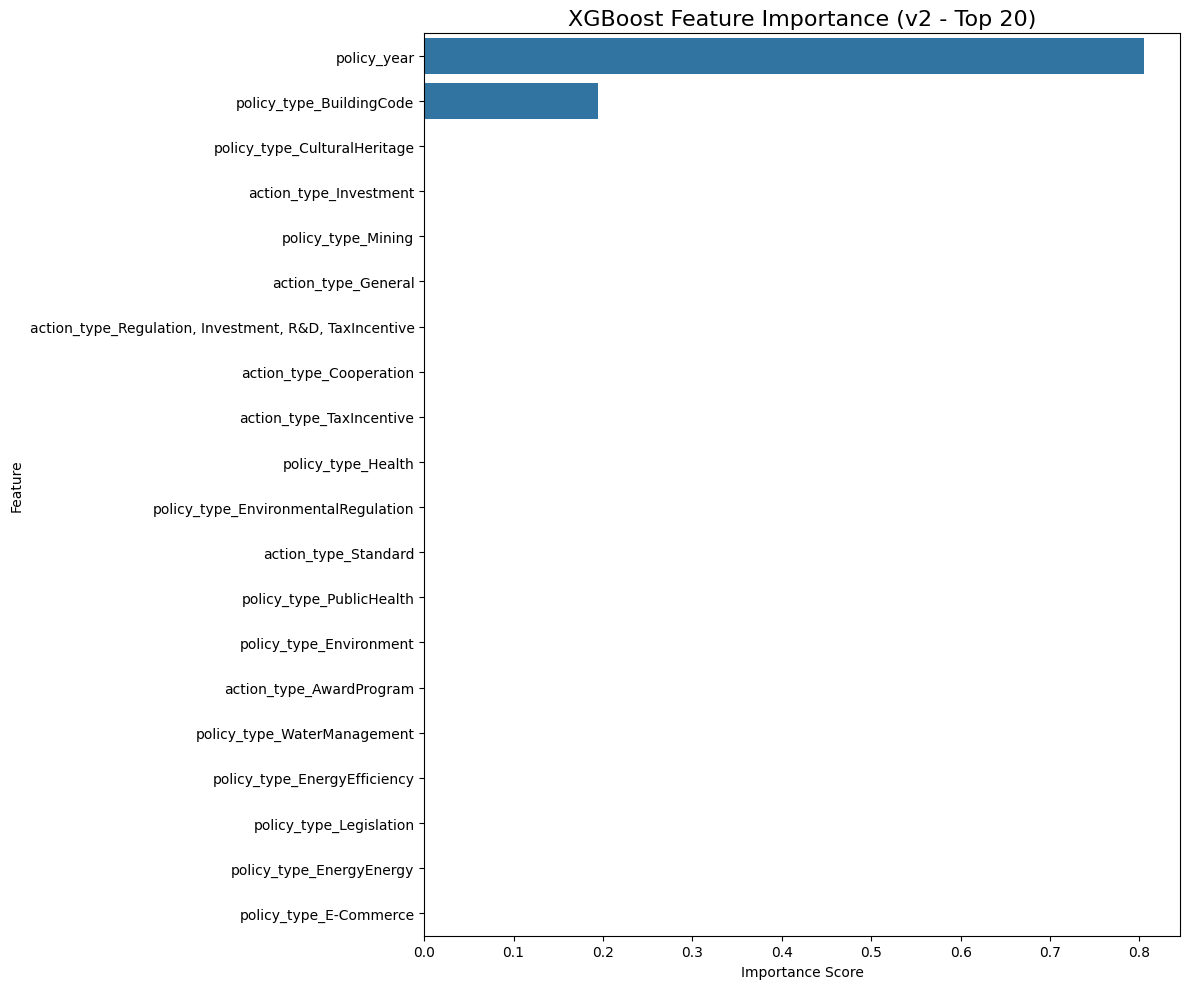


Top 5 most important features (v2):


,feature,importance
0,policy_year,0.805081
6,policy_type_BuildingCode,0.194425
18,policy_type_CulturalHeritage,0.000031
119,action_type_Investment,0.000026
76,policy_type_Mining,0.000025


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Plotting feature importance (v2)...")

# Get feature importance from the new model
feature_importances_v2 = pd.DataFrame({
    'feature': X_train_v2.columns,
    'importance': xg_reg_v2.feature_importances_
}).sort_values('importance', ascending=False)

# --- PLOTTING FIX: Only show the Top 20 ---
top_20_features = feature_importances_v2.head(20)

plt.figure(figsize=(12, 10)) # Made the figure taller
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('XGBoost Feature Importance (v2 - Top 20)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features (v2):")
display(feature_importances_v2.head())

In [14]:
# Check the distribution of pollutants
pollutant_counts = df_merged['pollutant'].value_counts()

print("--- Pollutant Data Counts ---")
print(pollutant_counts.head(10))

--- Pollutant Data Counts ---
pollutant
EDGAR_BC_1970_2022       607
EDGAR_CO_1970_2022       607
EDGAR_NH3_1970_2022      607
EDGAR_NMVOC_1970_2022    607
EDGAR_NOx_1970_2022      607
EDGAR_OC_1970_2022       607
EDGAR_PM10_1970_2022     607
EDGAR_PM2                607
EDGAR_SO2_1970_2022      607
HCB_1970_2018            607
Name: count, dtype: int64


In [15]:
# Import all necessary libraries for the function
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def train_specialist_model(df_full, pollutant_name, random_state=42):
    """
    Filters, trains, and evaluates an XGBoost model for a single pollutant.
    """
    print(f"\n=============================================")
    print(f"--- 🚀 Training Model for: {pollutant_name} ---")
    print(f"=============================================")
    
    # 1. Filter data for the specific pollutant
    df_pollutant = df_full[df_full['pollutant'] == pollutant_name].copy()
    
    # Safety check: Do we have enough data?
    if df_pollutant.shape[0] < 100:
        print(f"Skipping: Not enough data for {pollutant_name} (found {df_pollutant.shape[0]} samples).")
        return None
    
    # 2. Prepare Data (X and y)
    target_col = 'ate'
    # Our features are just the policy info and year
    feature_cols = ['policy_type', 'action_type', 'policy_year']
    
    # Drop NaNs
    df_model_data = df_pollutant.dropna(subset=[target_col] + feature_cols)
    
    # Safety check 2: Do we have enough *clean* data?
    if df_model_data.shape[0] < 100:
        print(f"Skipping: Not enough clean data for {pollutant_name} (found {df_model_data.shape[0]} samples).")
        return None
    
    print(f"Using {df_model_data.shape[0]} samples for {pollutant_name}.")
    
    # One-hot encode
    categorical_features = ['policy_type', 'action_type']
    df_processed = pd.get_dummies(df_model_data[feature_cols + [target_col]], 
                                  columns=categorical_features, 
                                  drop_first=True)
    
    y = df_processed[target_col]
    X = df_processed.drop(columns=[target_col])
    
    # 3. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # 4. Train Model
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                              n_estimators=100, 
                              learning_rate=0.1, 
                              max_depth=5, 
                              random_state=random_state)
    
    xg_reg.fit(X_train, y_train)
    
    # 5. Evaluate
    y_pred = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n--- ✅ Results for {pollutant_name} ---")
    print(f"  Target variable range: {y_test.min():.4f} to {y_test.max():.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    
    # 6. Plot Importance
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xg_reg.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_20_features = feature_importances.head(20)
    
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=top_20_features)
    plt.title(f'Feature Importance for {pollutant_name} (Top 20)', fontsize=16)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    # Return the results for comparison
    return {'pollutant': pollutant_name, 'r2': r2, 'rmse': rmse, 'samples': len(y), 'model': xg_reg}

print("Specialist training function `train_specialist_model` is defined.")

Specialist training function `train_specialist_model` is defined.


Will train specialist models for: ['EDGAR_PM2', 'EDGAR_SO2_1970_2022', 'EDGAR_NOx_1970_2022', 'EDGAR_CO_1970_2022']

--- 🚀 Training Model for: EDGAR_PM2 ---
Using 607 samples for EDGAR_PM2.

--- ✅ Results for EDGAR_PM2 ---
  Target variable range: -13.9902 to 13.1381
  R-squared (R²): 0.9999
  RMSE: 0.0713


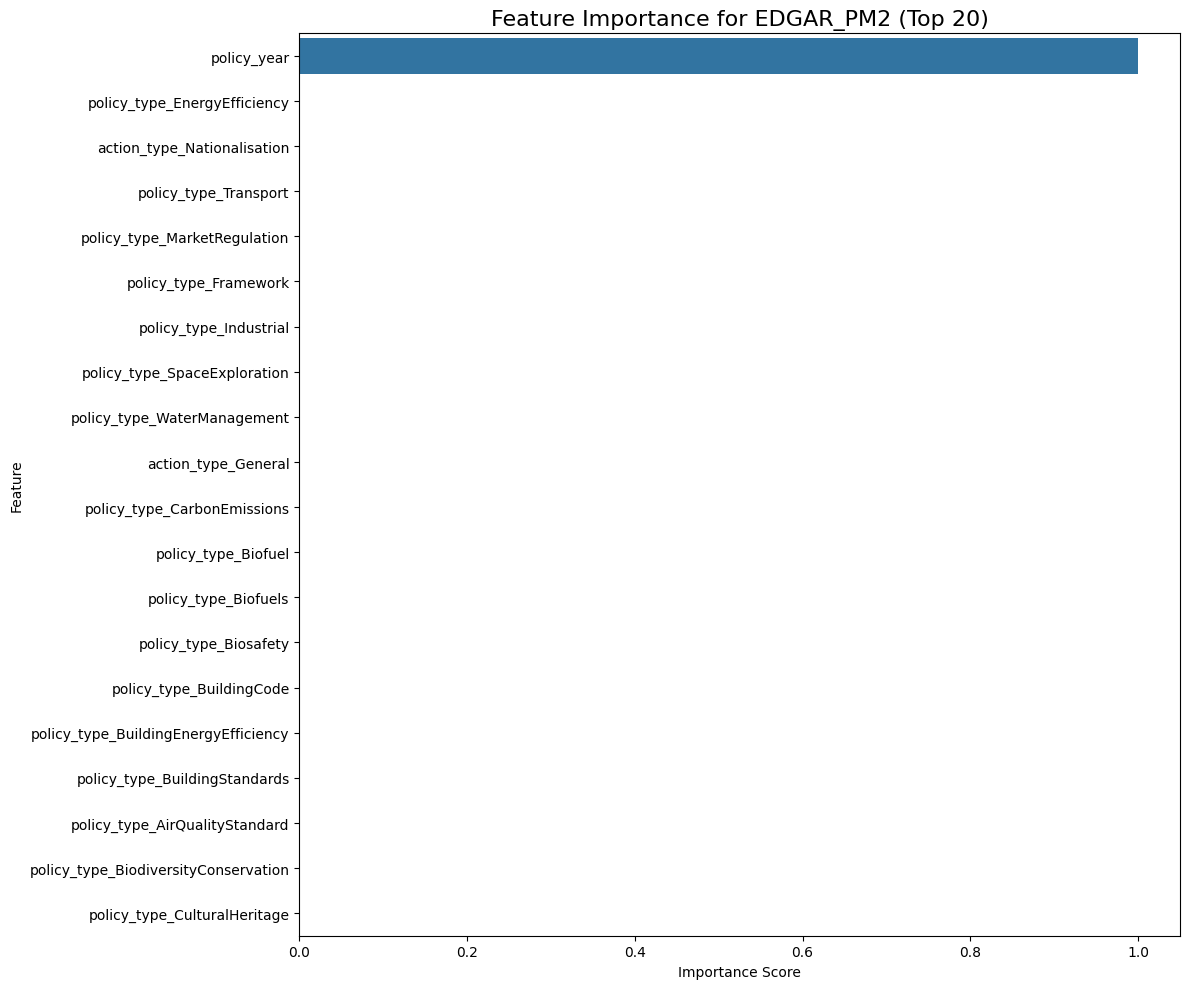


--- 🚀 Training Model for: EDGAR_SO2_1970_2022 ---
Using 607 samples for EDGAR_SO2_1970_2022.

--- ✅ Results for EDGAR_SO2_1970_2022 ---
  Target variable range: -56.3279 to 62.5061
  R-squared (R²): 0.9997
  RMSE: 0.7593


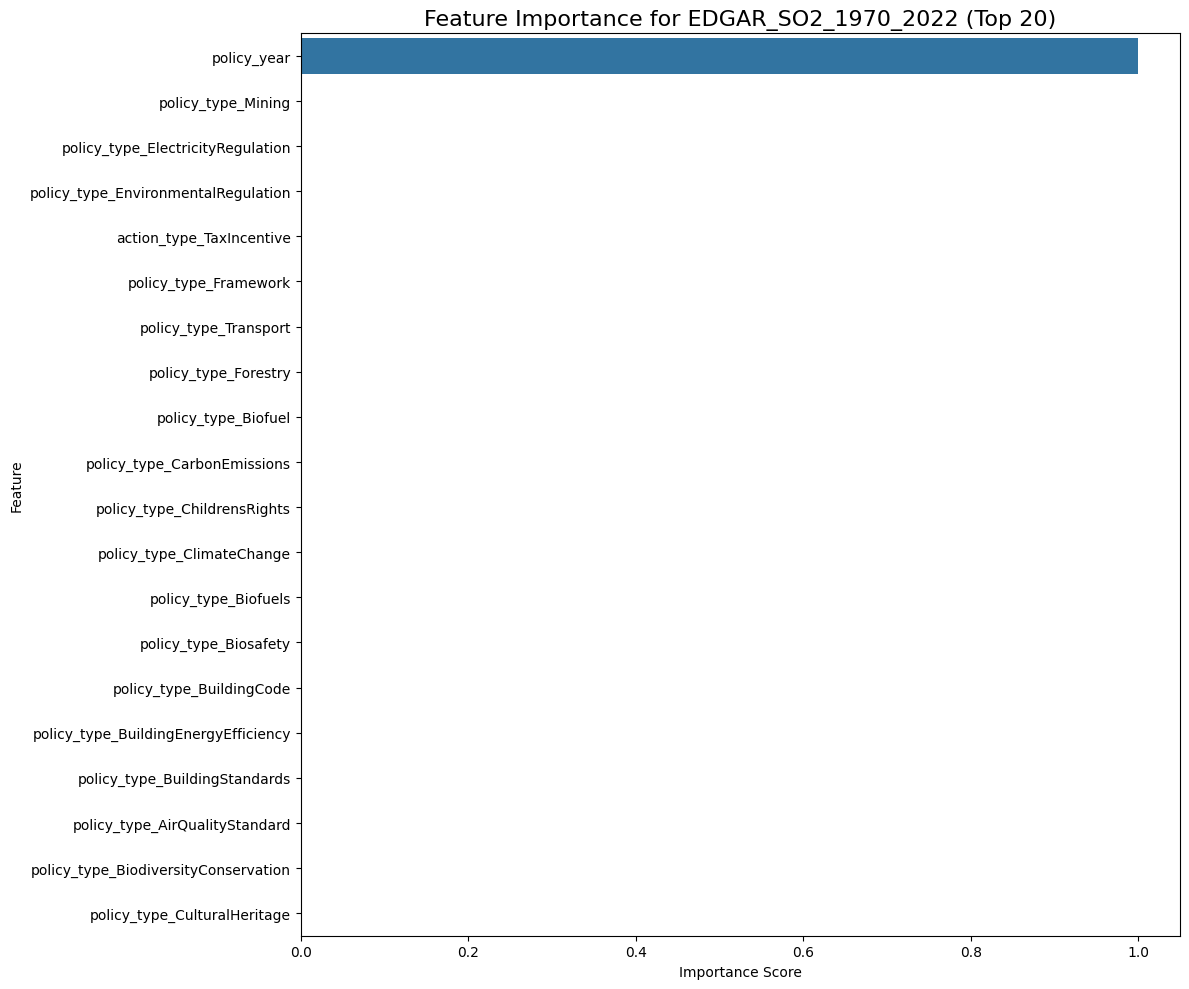


--- 🚀 Training Model for: EDGAR_NOx_1970_2022 ---
Using 607 samples for EDGAR_NOx_1970_2022.

--- ✅ Results for EDGAR_NOx_1970_2022 ---
  Target variable range: -30.5563 to 27.6191
  R-squared (R²): 0.9999
  RMSE: 0.2181


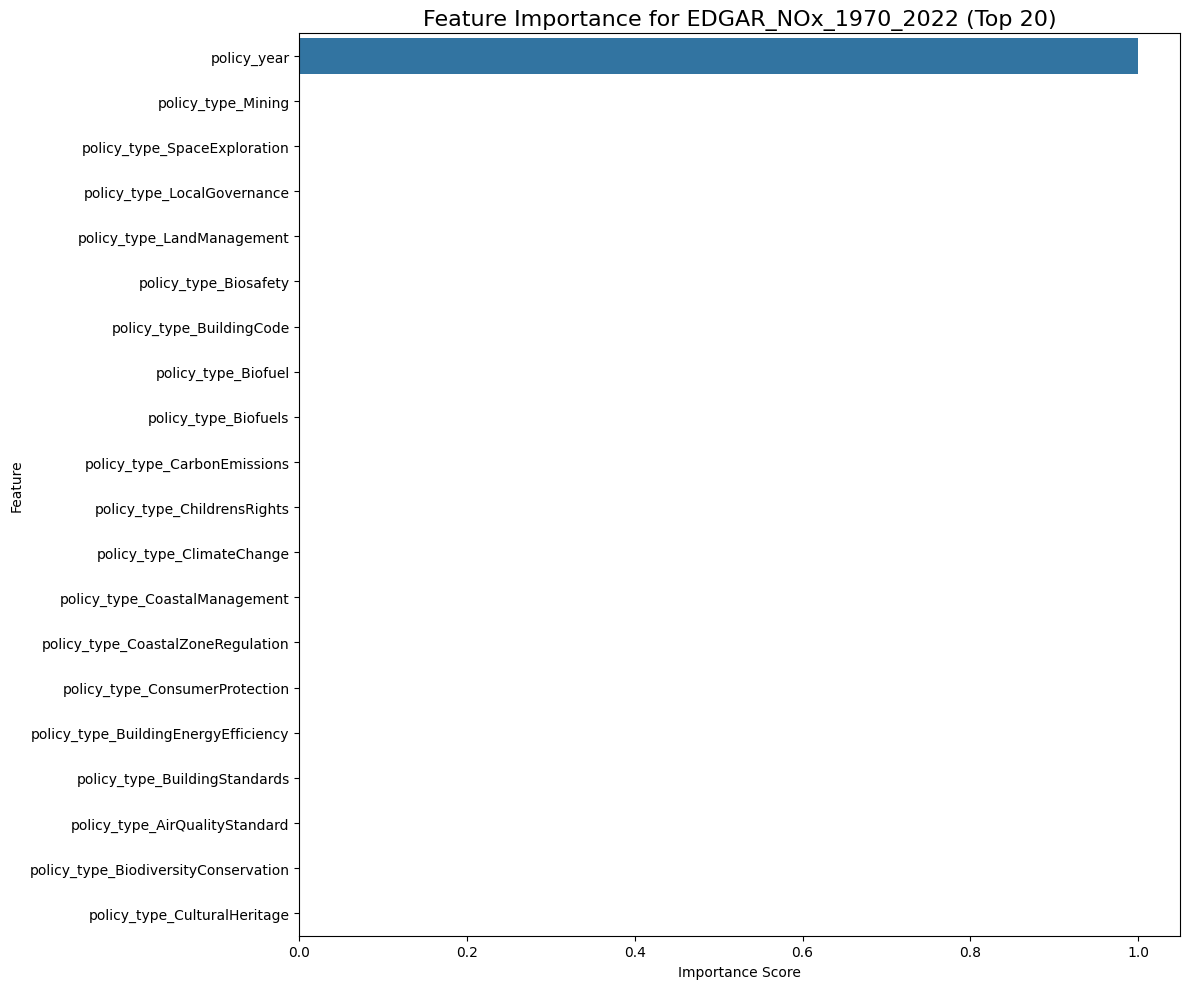


--- 🚀 Training Model for: EDGAR_CO_1970_2022 ---
Using 607 samples for EDGAR_CO_1970_2022.

--- ✅ Results for EDGAR_CO_1970_2022 ---
  Target variable range: -161.7773 to 156.7053
  R-squared (R²): 0.9999
  RMSE: 0.7756


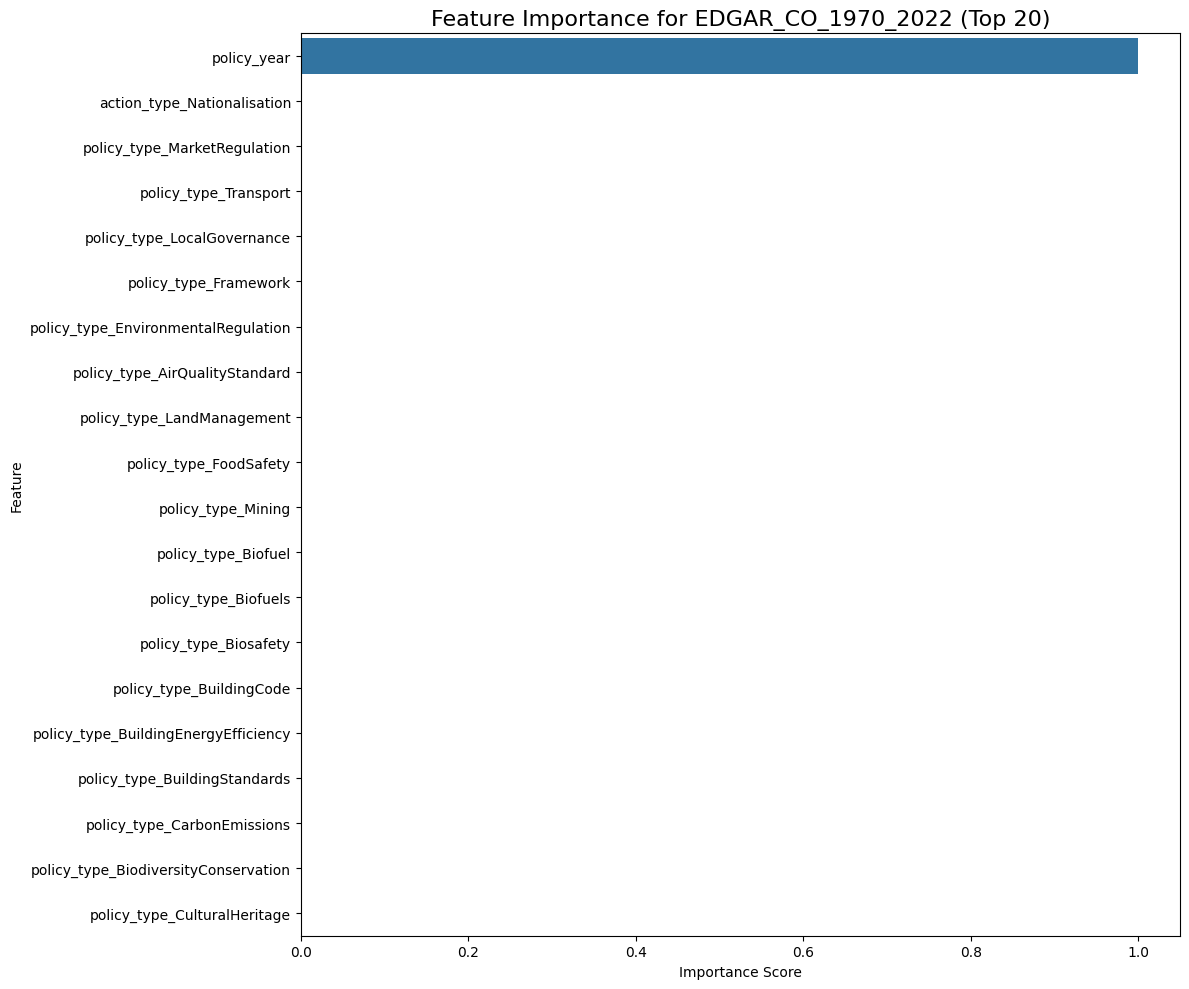


--- All Specialist Models Trained ---

--- Final Summary ---


,pollutant,r2,rmse,samples
EDGAR_PM2,EDGAR_PM2,0.999926,0.071320,607
EDGAR_SO2_1970_2022,EDGAR_SO2_1970_2022,0.999674,0.759278,607
EDGAR_NOx_1970_2022,EDGAR_NOx_1970_2022,0.999861,0.218068,607
EDGAR_CO_1970_2022,EDGAR_CO_1970_2022,0.999932,0.775590,607


In [16]:
# Manually define our target pollutants based on your list
pollutants_to_test = [
    'EDGAR_PM2',
    'EDGAR_SO2_1970_2022',
    'EDGAR_NOx_1970_2022',
    'EDGAR_CO_1970_2022'
]
print(f"Will train specialist models for: {pollutants_to_test}")

# Loop and train
specialist_results = {}
for pollutant in pollutants_to_test:
    results = train_specialist_model(df_merged, 
                                     pollutant, 
                                     random_state=RANDOM_STATE)
    if results:
        specialist_results[pollutant] = results

print("\n--- All Specialist Models Trained ---")

# Show a final summary
if specialist_results:
    df_summary = pd.DataFrame.from_dict(specialist_results, orient='index')
    df_summary = df_summary.drop(columns=['model']) # Don't print the model object
    print("\n--- Final Summary ---")
    display(df_summary)
else:
    print("No models were successfully trained.")